# Ask-Tell Optimization Interface

In this notebook we will illustrate the use of an Ask-Tell interface in Trieste. It is useful for cases where you want to have greater control of the optimization loop, or when letting Trieste manage this loop is impossible.

First, some code to set up the problem we will be using throughout the notebook. If you would like more details about this problem setup, please refer to [introductory EI notebook](expected_improvement.ipynb).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow

from trieste.ask_tell_optimization import AskTellOptimizer
from trieste.bayesian_optimizer import Record
from trieste.data import Dataset
from trieste.models.gpflow.models import GaussianProcessRegression
from trieste.objectives import scaled_branin, SCALED_BRANIN_MINIMUM
from trieste.objectives.utils import mk_observer
from trieste.space import Box

from util.plotting import plot_regret

np.random.seed(1234)
tf.random.set_seed(1234)


search_space = Box([0, 0], [1, 1])
n_steps = 5


def build_model(data, kernel_func=None):
    """kernel_func should be a function that takes variance as a single input parameter"""
    variance = tf.math.reduce_variance(data.observations)
    if kernel_func is None:
        kernel = gpflow.kernels.Matern52(variance=variance)
    else:
        kernel = kernel_func(variance)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)


num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
observer = mk_observer(scaled_branin)
initial_data = observer(initial_query_points)

## Timing acquisition function: simple use case for Ask-Tell

Let's say we are very concerned with the performance of the acquisition function, and want a simple way of measuring its performance over the course of the optimization. At the time of writing these lines, regular Trieste's optimizer does not provide such customization functionality, and this is where Ask-Tell comes in handy.

In [2]:
import timeit

model = build_model(initial_data)
ask_tell = AskTellOptimizer(search_space, initial_data, model)

for step in range(n_steps):
    start = timeit.default_timer()
    new_point = ask_tell.ask()
    stop = timeit.default_timer()

    print(f"Time at step {step + 1}: {stop - start}")

    new_data = observer(new_point)
    ask_tell.tell(new_data)

Time at step 1: 1.4399191869999868


Time at step 2: 0.03943983400000661


Time at step 3: 0.04341808700002048


Time at step 4: 0.04348008600004505


Time at step 5: 0.05096999799997093


Once ask-tell optimization is over, you can extract an optimization result object and perform whatever analysis you need, just like with regular Trieste optimization interface. For instance, here we will plot regret for each optimization step.

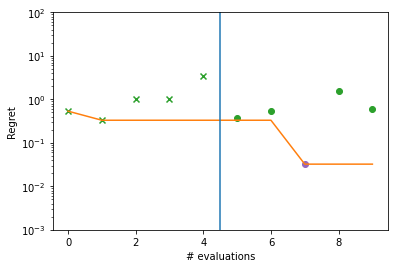

In [3]:
def plot_ask_tell_regret(ask_tell_result):
    observations = ask_tell_result.try_get_final_dataset().observations.numpy()
    arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

    suboptimality = observations - SCALED_BRANIN_MINIMUM.numpy()
    ax = plt.gca()
    plot_regret(
        suboptimality, ax, num_init=num_initial_points, idx_best=arg_min_idx
    )

    ax.set_yscale("log")
    ax.set_ylabel("Regret")
    ax.set_ylim(0.001, 100)
    ax.set_xlabel("# evaluations")


plot_ask_tell_regret(ask_tell.to_result())

## Model selection: using only Ask part

We now turn to a slightly more complex use case. Let's suppose we want to switch between two models depending on some criteria dynamically during the optimization loop, e.g. we want to be able to train a model outside of Trieste. In this case we can only use Ask part of the Ask-Tell interface.

Using model 1
Asking for new point to observe


Training models externally


Using model 2
Asking for new point to observe


Training models externally


Using model 1
Asking for new point to observe


Training models externally


Using model 2
Asking for new point to observe


Training models externally


Using model 1
Asking for new point to observe


Training models externally


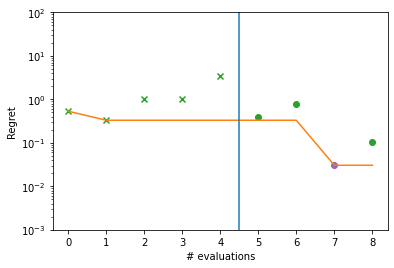

In [4]:
model1 = build_model(
    initial_data, kernel_func=lambda v: gpflow.kernels.RBF(variance=v)
)
model2 = build_model(
    initial_data, kernel_func=lambda v: gpflow.kernels.Matern32(variance=v)
)

dataset = initial_data
for step in range(n_steps):
    # this criterion is meaningless
    # but hopefully illustrates the idea!
    if step % 2 == 0:
        print("Using model 1")
        model = model1
    else:
        print("Using model 2")
        model = model2

    print("Asking for new point to observe")
    ask_tell = AskTellOptimizer(search_space, dataset, model)
    new_point = ask_tell.ask()

    new_data_point = observer(new_point)
    dataset = dataset + new_data_point

    print("Training models externally")
    model1.update(dataset)
    model1.optimize(dataset)

    model2.update(dataset)
    model2.optimize(dataset)

plot_ask_tell_regret(ask_tell.to_result())

## External experiment: storing optimizer state

Now let's suppose you are optimizing a process that takes hours or even days to complete, e.g. a lab experiment or a hyperparameter optimization of a big machine learning model. This time you cannot even express the objective function in Python code. Instead you would like to ask Trieste what configuration to run next, go to the lab, perform the experiment, collect data, feed it back to Trieste and ask for the next configuration, and so on. It would be very convenient to be able to store intermediate optimization state to disk or database or other storage, so that your machine can be switched off while you are waiting for observation results.

In this section we'll show how you could do it with Ask-Tell in Trieste. Of course we cannot perform a real physical experiment within this notebook, so we will just mimick it by using pickle to write optimization state and read it back.

Ask Trieste for configuration #0


Saving Trieste state to re-use later
In the lab running the experiment #0.
Back from the lab
Restore optimizer from the saved state


Ask Trieste for configuration #1


Saving Trieste state to re-use later
In the lab running the experiment #1.
Back from the lab
Restore optimizer from the saved state


Ask Trieste for configuration #2


Saving Trieste state to re-use later
In the lab running the experiment #2.
Back from the lab
Restore optimizer from the saved state


Ask Trieste for configuration #3


Saving Trieste state to re-use later
In the lab running the experiment #3.
Back from the lab
Restore optimizer from the saved state


Ask Trieste for configuration #4


Saving Trieste state to re-use later
In the lab running the experiment #4.
Back from the lab
Restore optimizer from the saved state


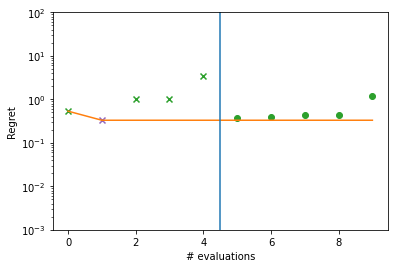

In [5]:
import pickle

model = build_model(initial_data)
ask_tell = AskTellOptimizer(search_space, initial_data, model)
for step in range(n_steps):
    print(f"Ask Trieste for configuration #{step}")
    new_config = ask_tell.ask()

    print("Saving Trieste state to re-use later")
    state: Record[None] = ask_tell.to_record()
    saved_state = pickle.dumps(state)

    print(f"In the lab running the experiment #{step}.")
    new_datapoint = scaled_branin(new_config)

    print("Back from the lab")
    print("Restore optimizer from the saved state")
    loaded_state = pickle.loads(saved_state)
    ask_tell = AskTellOptimizer.from_record(loaded_state, search_space)
    ask_tell.tell(Dataset(new_config, new_datapoint))


plot_ask_tell_regret(ask_tell.to_result())

A word of warning. This serialization technique is not guaranteed to work smoothly with every Tensorflow-based model, so apply to your own problems with caution.